# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.321
[3] loss: 0.148
[4] loss: 0.087
[5] loss: 0.055
[6] loss: 0.036
[7] loss: 0.027
[8] loss: 0.020
[9] loss: 0.016
[10] loss: 0.010
[11] loss: 0.010
[12] loss: 0.007
[13] loss: 0.009
[14] loss: 0.010
[15] loss: 0.004
[16] loss: 0.004
[17] loss: 0.004
[18] loss: 0.006
[19] loss: 0.003
[20] loss: 0.005
[21] loss: 0.003
[22] loss: 0.004
[23] loss: 0.003
[24] loss: 0.002
[25] loss: 0.001


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

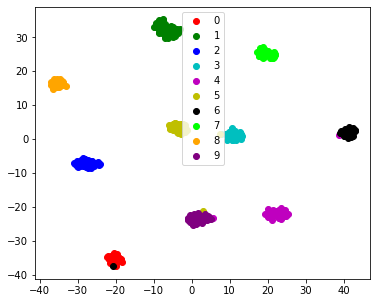

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

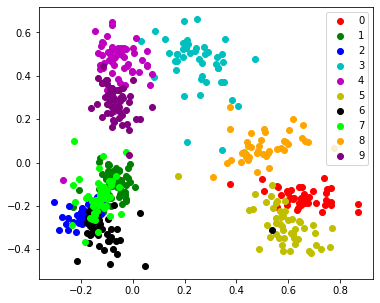

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [12]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[ 0.6388, -0.0884, -0.1751,  0.2192, -0.0721,  0.5494, -0.1125, -0.1360,
          0.4976, -0.0826],
        [ 0.4453, -0.2081, -0.2839, -0.2304,  0.3685, -0.2509,  0.4192,  0.2891,
         -0.1840,  0.0563],
        [-0.1559, -0.1149, -0.2394,  0.4675,  0.4893, -0.2990, -0.2868, -0.1726,
          0.0629,  0.2949],
        [-0.1600,  0.4189, -0.2122, -0.1213,  0.1041, -0.1560, -0.1763,  0.5876,
          0.4729, -0.1803],
        [-0.2443, -0.1407, -0.2515,  0.0750, -0.2842,  0.5653,  0.1895,  0.2706,
         -0.1153,  0.6270],
        [-0.1432,  0.4275, -0.2384,  0.3786, -0.1260, -0.0107,  0.4784, -0.2148,
         -0.2461, -0.1733]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_12.cfg')

['./config/sswae_dev2_12.cfg']

In [5]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/mu_{y_dim}.pt'))
mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 8
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [001/100]  loss: 2.326549e-01  D: 6.902786e-01  D2: 4.489505e-02  D3: 2.356549e-03
test loss: 1.644731e-01  D: 6.940709e-01  D2: 1.412734e-02  D3: 5.777194e-03


[default |INFO|model.py:1280] [002/100]  loss: 1.541127e-01  D: 6.964328e-01  D2: 3.753436e-03  D3: 6.669614e-03
test loss: 1.368461e-01  D: 6.915464e-01  D2: -3.733826e-04  D3: 6.670380e-03


[default |INFO|model.py:1280] [003/100]  loss: 1.238196e-01  D: 6.942307e-01  D2: -1.637985e-03  D3: 6.834119e-03
test loss: 1.037221e-01  D: 7.062682e-01  D2: -2.162762e-03  D3: 7.673677e-03


[default |INFO|model.py:1280] [004/100]  loss: 9.940366e-02  D: 6.765202e-01  D2: -3.933628e-03  D3: 8.531942e-03
test loss: 8.784250e-02  D: 7.008485e-01  D2: -4.898186e-03  D3: 8.699184e-03


[default |INFO|model.py:1280] [005/100]  loss: 9.328189e-02  D: 6.982826e-01  D2: -4.651033e-03  D3: 1.131774e-02
test loss: 8.583919e-02  D: 6.701613e-01  D2: -4.203043e-03  D3: 1.026521e-02


[default |INFO|model.py:1280] [006/100]  loss: 7.817127e-02  D: 6.954489e-01  D2: -4.882270e-03  D3: 1.104691e-02
test loss: 7.648586e-02  D: 7.228921e-01  D2: -5.190248e-03  D3: 1.318842e-02


[default |INFO|model.py:1280] [007/100]  loss: 8.257202e-02  D: 6.941325e-01  D2: -4.931326e-03  D3: 1.355514e-02
test loss: 7.609352e-02  D: 6.878976e-01  D2: -4.959145e-03  D3: 1.301438e-02


[default |INFO|model.py:1280] [008/100]  loss: 9.047260e-02  D: 6.985864e-01  D2: -4.886041e-03  D3: 1.515678e-02
test loss: 7.606310e-02  D: 6.961567e-01  D2: -5.382986e-03  D3: 1.166967e-02


[default |INFO|model.py:1280] [009/100]  loss: 7.921805e-02  D: 6.962936e-01  D2: -5.588814e-03  D3: 1.393729e-02
test loss: 7.942716e-02  D: 6.999406e-01  D2: -5.976334e-03  D3: 1.492943e-02


[default |INFO|model.py:1280] [010/100]  loss: 7.221012e-02  D: 6.928134e-01  D2: -5.546312e-03  D3: 1.545381e-02
test loss: 7.097563e-02  D: 6.910612e-01  D2: -5.738640e-03  D3: 1.602259e-02


[default |INFO|model.py:1280] [011/100]  loss: 6.686268e-02  D: 6.937052e-01  D2: -5.634457e-03  D3: 1.561919e-02
test loss: 6.408721e-02  D: 6.898273e-01  D2: -5.911951e-03  D3: 1.452573e-02


[default |INFO|model.py:1280] [012/100]  loss: 6.436441e-02  D: 6.925709e-01  D2: -6.231346e-03  D3: 1.513633e-02
test loss: 6.404732e-02  D: 7.014875e-01  D2: -5.218191e-03  D3: 1.445686e-02


[default |INFO|model.py:1280] [013/100]  loss: 6.342706e-02  D: 6.951216e-01  D2: -6.320337e-03  D3: 1.455049e-02
test loss: 6.389128e-02  D: 7.234076e-01  D2: -6.261587e-03  D3: 1.418687e-02


[default |INFO|model.py:1280] [014/100]  loss: 6.402426e-02  D: 6.923081e-01  D2: -6.381102e-03  D3: 1.475490e-02
test loss: 7.060764e-02  D: 6.842634e-01  D2: -5.769033e-03  D3: 1.820513e-02


[default |INFO|model.py:1280] [015/100]  loss: 6.069285e-02  D: 6.921163e-01  D2: -6.579108e-03  D3: 1.487718e-02
test loss: 5.969872e-02  D: 7.026935e-01  D2: -6.127548e-03  D3: 1.242563e-02


[default |INFO|model.py:1280] [016/100]  loss: 6.079797e-02  D: 6.937169e-01  D2: -6.882202e-03  D3: 1.425987e-02
test loss: 5.722270e-02  D: 6.921595e-01  D2: -7.013779e-03  D3: 1.422771e-02


[default |INFO|model.py:1280] [017/100]  loss: 5.994391e-02  D: 6.962486e-01  D2: -6.967080e-03  D3: 1.341533e-02
test loss: 6.373320e-02  D: 7.246965e-01  D2: -7.412195e-03  D3: 1.538183e-02


[default |INFO|model.py:1280] [018/100]  loss: 5.999036e-02  D: 6.927808e-01  D2: -7.154217e-03  D3: 1.301145e-02
test loss: 5.978762e-02  D: 7.020619e-01  D2: -7.306452e-03  D3: 1.497649e-02


[default |INFO|model.py:1280] [019/100]  loss: 5.654154e-02  D: 6.950801e-01  D2: -7.207519e-03  D3: 1.449076e-02
test loss: 5.816396e-02  D: 6.912842e-01  D2: -7.206326e-03  D3: 1.285405e-02


[default |INFO|model.py:1280] [020/100]  loss: 6.058542e-02  D: 6.949229e-01  D2: -7.420438e-03  D3: 1.208630e-02
test loss: 5.686003e-02  D: 6.853891e-01  D2: -8.288975e-03  D3: 1.201115e-02


[default |INFO|model.py:1280] [021/100]  loss: 5.760881e-02  D: 6.942907e-01  D2: -7.639788e-03  D3: 1.407366e-02
test loss: 5.767283e-02  D: 7.047067e-01  D2: -8.153591e-03  D3: 1.635521e-02


[default |INFO|model.py:1280] [022/100]  loss: 5.644413e-02  D: 6.937813e-01  D2: -7.767336e-03  D3: 1.405219e-02
test loss: 5.702381e-02  D: 6.881301e-01  D2: -7.907705e-03  D3: 1.335624e-02


[default |INFO|model.py:1280] [023/100]  loss: 5.570584e-02  D: 6.949228e-01  D2: -7.868373e-03  D3: 1.339608e-02
test loss: 5.684913e-02  D: 7.003435e-01  D2: -7.404671e-03  D3: 1.512907e-02


[default |INFO|model.py:1280] [024/100]  loss: 5.524348e-02  D: 6.940600e-01  D2: -8.076704e-03  D3: 1.359525e-02
test loss: 5.828480e-02  D: 6.632711e-01  D2: -8.487911e-03  D3: 1.467095e-02


[default |INFO|model.py:1280] [025/100]  loss: 5.458347e-02  D: 6.918048e-01  D2: -8.111884e-03  D3: 1.404373e-02
test loss: 5.282452e-02  D: 6.905053e-01  D2: -7.932873e-03  D3: 1.629106e-02


[default |INFO|model.py:1280] [026/100]  loss: 5.364068e-02  D: 6.949573e-01  D2: -8.326847e-03  D3: 1.403188e-02
test loss: 5.434787e-02  D: 6.979552e-01  D2: -7.954731e-03  D3: 1.161857e-02


[default |INFO|model.py:1280] [027/100]  loss: 5.770116e-02  D: 6.956449e-01  D2: -8.392588e-03  D3: 1.261217e-02
test loss: 5.758768e-02  D: 6.936824e-01  D2: -8.915901e-03  D3: 1.634621e-02


[default |INFO|model.py:1280] [028/100]  loss: 5.642073e-02  D: 6.947176e-01  D2: -8.459056e-03  D3: 1.274635e-02
test loss: 5.441622e-02  D: 6.947592e-01  D2: -8.667021e-03  D3: 1.406726e-02


[default |INFO|model.py:1280] [029/100]  loss: 5.464288e-02  D: 6.940633e-01  D2: -8.561257e-03  D3: 1.363588e-02
test loss: 5.313614e-02  D: 6.748055e-01  D2: -8.708611e-03  D3: 1.394622e-02


[default |INFO|model.py:1280] [030/100]  loss: 5.504656e-02  D: 6.946930e-01  D2: -8.589336e-03  D3: 1.320682e-02
test loss: 5.563042e-02  D: 6.840497e-01  D2: -8.394976e-03  D3: 1.200459e-02


[default |INFO|model.py:1280] [031/100]  loss: 5.427845e-02  D: 6.934337e-01  D2: -8.734784e-03  D3: 1.306620e-02
test loss: 5.733361e-02  D: 6.888021e-01  D2: -8.867006e-03  D3: 1.454183e-02


[default |INFO|model.py:1280] [032/100]  loss: 5.234727e-02  D: 6.928028e-01  D2: -8.837142e-03  D3: 1.369791e-02
test loss: 5.381002e-02  D: 6.915899e-01  D2: -9.051800e-03  D3: 1.665662e-02


[default |INFO|model.py:1280] [033/100]  loss: 5.384105e-02  D: 6.942323e-01  D2: -8.873731e-03  D3: 1.338181e-02
test loss: 5.305215e-02  D: 6.859242e-01  D2: -9.330835e-03  D3: 1.323966e-02


[default |INFO|model.py:1280] [034/100]  loss: 5.317356e-02  D: 6.956530e-01  D2: -9.009843e-03  D3: 1.333729e-02
test loss: 5.703387e-02  D: 6.817121e-01  D2: -8.748922e-03  D3: 1.633146e-02


[default |INFO|model.py:1280] [035/100]  loss: 5.302182e-02  D: 6.931057e-01  D2: -9.040871e-03  D3: 1.288618e-02
test loss: 5.296812e-02  D: 6.863332e-01  D2: -8.675985e-03  D3: 1.417069e-02


[default |INFO|model.py:1280] [036/100]  loss: 4.919429e-02  D: 6.946199e-01  D2: -9.108318e-03  D3: 1.406086e-02
test loss: 5.094589e-02  D: 6.882327e-01  D2: -9.719286e-03  D3: 1.352166e-02


[default |INFO|model.py:1280] [037/100]  loss: 4.981284e-02  D: 6.914956e-01  D2: -9.303573e-03  D3: 1.361306e-02
test loss: 5.095849e-02  D: 6.873894e-01  D2: -9.341345e-03  D3: 1.091988e-02


[default |INFO|model.py:1280] [038/100]  loss: 5.073565e-02  D: 6.958614e-01  D2: -9.234328e-03  D3: 1.337724e-02
test loss: 4.954434e-02  D: 6.955073e-01  D2: -8.853579e-03  D3: 1.461900e-02


[default |INFO|model.py:1280] [039/100]  loss: 4.990664e-02  D: 6.928457e-01  D2: -9.369243e-03  D3: 1.324070e-02
test loss: 4.994644e-02  D: 6.999652e-01  D2: -9.425573e-03  D3: 1.124993e-02


[default |INFO|model.py:1280] [040/100]  loss: 5.015835e-02  D: 6.939244e-01  D2: -9.413063e-03  D3: 1.319147e-02
test loss: 4.986017e-02  D: 7.090390e-01  D2: -9.672794e-03  D3: 1.345887e-02


[default |INFO|model.py:1280] [041/100]  loss: 4.868965e-02  D: 6.930524e-01  D2: -9.472620e-03  D3: 1.334834e-02
test loss: 5.051672e-02  D: 6.923758e-01  D2: -9.518232e-03  D3: 1.351336e-02


[default |INFO|model.py:1280] [042/100]  loss: 4.949478e-02  D: 6.950713e-01  D2: -9.564551e-03  D3: 1.311439e-02
test loss: 4.876257e-02  D: 6.767688e-01  D2: -9.310465e-03  D3: 1.404508e-02


[default |INFO|model.py:1280] [043/100]  loss: 4.997512e-02  D: 6.942191e-01  D2: -9.629401e-03  D3: 1.307068e-02
test loss: 4.984126e-02  D: 6.810229e-01  D2: -9.631214e-03  D3: 1.296626e-02


[default |INFO|model.py:1280] [044/100]  loss: 4.857140e-02  D: 6.949388e-01  D2: -9.702250e-03  D3: 1.326809e-02
test loss: 4.816362e-02  D: 6.928638e-01  D2: -9.349184e-03  D3: 1.333919e-02


[default |INFO|model.py:1280] [045/100]  loss: 4.797442e-02  D: 6.935245e-01  D2: -9.735459e-03  D3: 1.292675e-02
test loss: 4.650508e-02  D: 6.862086e-01  D2: -9.901266e-03  D3: 1.487553e-02


[default |INFO|model.py:1280] [046/100]  loss: 4.684694e-02  D: 6.925419e-01  D2: -9.734081e-03  D3: 1.360561e-02
test loss: 4.721284e-02  D: 6.920235e-01  D2: -1.007199e-02  D3: 1.259604e-02


[default |INFO|model.py:1280] [047/100]  loss: 4.775756e-02  D: 6.934321e-01  D2: -9.858670e-03  D3: 1.293586e-02
test loss: 4.855731e-02  D: 7.025734e-01  D2: -9.930410e-03  D3: 1.507434e-02


[default |INFO|model.py:1280] [048/100]  loss: 4.736457e-02  D: 6.927085e-01  D2: -9.884475e-03  D3: 1.312097e-02
test loss: 4.538683e-02  D: 7.059419e-01  D2: -1.001878e-02  D3: 1.221126e-02


[default |INFO|model.py:1280] [049/100]  loss: 4.714228e-02  D: 6.959048e-01  D2: -9.928880e-03  D3: 1.306464e-02
test loss: 4.777897e-02  D: 6.906556e-01  D2: -9.953747e-03  D3: 1.221504e-02


[default |INFO|model.py:1280] [050/100]  loss: 4.574525e-02  D: 6.933680e-01  D2: -9.932949e-03  D3: 1.342818e-02
test loss: 4.860803e-02  D: 6.826970e-01  D2: -9.827414e-03  D3: 1.325639e-02


[default |INFO|model.py:1280] [051/100]  loss: 4.508905e-02  D: 6.947099e-01  D2: -1.000883e-02  D3: 1.340698e-02
test loss: 4.553904e-02  D: 6.979265e-01  D2: -9.955530e-03  D3: 1.356845e-02


[default |INFO|model.py:1280] [052/100]  loss: 4.514867e-02  D: 6.936878e-01  D2: -1.010476e-02  D3: 1.327980e-02
test loss: 4.552666e-02  D: 6.865892e-01  D2: -1.013478e-02  D3: 1.415855e-02


[default |INFO|model.py:1280] [053/100]  loss: 4.475355e-02  D: 6.944398e-01  D2: -1.003432e-02  D3: 1.323022e-02
test loss: 4.764815e-02  D: 6.935624e-01  D2: -9.730606e-03  D3: 1.223070e-02


[default |INFO|model.py:1280] [054/100]  loss: 4.502315e-02  D: 6.933805e-01  D2: -1.011269e-02  D3: 1.315049e-02
test loss: 4.765640e-02  D: 6.831372e-01  D2: -1.016516e-02  D3: 1.175174e-02


[default |INFO|model.py:1280] [055/100]  loss: 4.624781e-02  D: 6.938901e-01  D2: -1.011455e-02  D3: 1.278679e-02
test loss: 4.944871e-02  D: 6.935326e-01  D2: -1.040351e-02  D3: 9.654816e-03


[default |INFO|model.py:1280] [056/100]  loss: 4.649473e-02  D: 6.945773e-01  D2: -1.012787e-02  D3: 1.276474e-02
test loss: 4.748528e-02  D: 6.983009e-01  D2: -9.863615e-03  D3: 1.491748e-02


[default |INFO|model.py:1280] [057/100]  loss: 4.427566e-02  D: 6.931768e-01  D2: -1.016877e-02  D3: 1.330590e-02
test loss: 4.599103e-02  D: 6.910716e-01  D2: -1.002647e-02  D3: 1.345159e-02


[default |INFO|model.py:1280] [058/100]  loss: 4.417945e-02  D: 6.934804e-01  D2: -1.020473e-02  D3: 1.315635e-02
test loss: 4.491815e-02  D: 6.984246e-01  D2: -1.026869e-02  D3: 1.297081e-02


[default |INFO|model.py:1280] [059/100]  loss: 4.485672e-02  D: 6.927535e-01  D2: -1.017760e-02  D3: 1.311927e-02
test loss: 4.669323e-02  D: 6.820468e-01  D2: -1.035383e-02  D3: 1.303313e-02


[default |INFO|model.py:1280] [060/100]  loss: 4.391913e-02  D: 6.929025e-01  D2: -1.021277e-02  D3: 1.296083e-02
test loss: 4.432749e-02  D: 6.946907e-01  D2: -1.043523e-02  D3: 1.356245e-02


[default |INFO|model.py:1280] [061/100]  loss: 4.472851e-02  D: 6.939000e-01  D2: -1.026971e-02  D3: 1.299812e-02
test loss: 4.871857e-02  D: 7.099270e-01  D2: -9.875412e-03  D3: 1.309859e-02


[default |INFO|model.py:1280] [062/100]  loss: 4.445594e-02  D: 6.934097e-01  D2: -1.025232e-02  D3: 1.284593e-02
test loss: 4.857963e-02  D: 6.922324e-01  D2: -1.048266e-02  D3: 1.200290e-02


[default |INFO|model.py:1280] [063/100]  loss: 4.426372e-02  D: 6.935749e-01  D2: -1.031043e-02  D3: 1.299200e-02
test loss: 4.558065e-02  D: 6.940235e-01  D2: -1.028170e-02  D3: 1.077968e-02


[default |INFO|model.py:1280] [064/100]  loss: 4.367092e-02  D: 6.935225e-01  D2: -1.025313e-02  D3: 1.287961e-02
test loss: 4.551698e-02  D: 6.853480e-01  D2: -1.035919e-02  D3: 1.340506e-02


[default |INFO|model.py:1280] [065/100]  loss: 4.342662e-02  D: 6.935007e-01  D2: -1.031809e-02  D3: 1.282182e-02
test loss: 4.831174e-02  D: 7.030809e-01  D2: -1.022574e-02  D3: 1.381241e-02


[default |INFO|model.py:1280] [066/100]  loss: 4.385188e-02  D: 6.935131e-01  D2: -1.030849e-02  D3: 1.263294e-02
test loss: 4.322964e-02  D: 7.014977e-01  D2: -1.034829e-02  D3: 1.268462e-02


[default |INFO|model.py:1280] [067/100]  loss: 4.303505e-02  D: 6.930324e-01  D2: -1.035534e-02  D3: 1.304287e-02
test loss: 4.581848e-02  D: 6.936915e-01  D2: -1.034719e-02  D3: 1.191742e-02


[default |INFO|model.py:1280] [068/100]  loss: 4.308092e-02  D: 6.933820e-01  D2: -1.042693e-02  D3: 1.266707e-02
test loss: 4.563852e-02  D: 6.905749e-01  D2: -1.020246e-02  D3: 1.299524e-02


[default |INFO|model.py:1280] [069/100]  loss: 4.407819e-02  D: 6.943681e-01  D2: -1.033363e-02  D3: 1.273834e-02
test loss: 4.496233e-02  D: 6.943577e-01  D2: -1.060408e-02  D3: 1.174046e-02


[default |INFO|model.py:1280] [070/100]  loss: 4.287466e-02  D: 6.927589e-01  D2: -1.045947e-02  D3: 1.263086e-02
test loss: 4.422771e-02  D: 7.095800e-01  D2: -1.051832e-02  D3: 1.276294e-02


[default |INFO|model.py:1280] [071/100]  loss: 4.439186e-02  D: 6.945534e-01  D2: -1.039262e-02  D3: 1.253508e-02
test loss: 4.646841e-02  D: 6.970992e-01  D2: -1.053511e-02  D3: 1.289181e-02


[default |INFO|model.py:1280] [072/100]  loss: 4.338361e-02  D: 6.949589e-01  D2: -1.040029e-02  D3: 1.270126e-02
test loss: 4.569170e-02  D: 6.966832e-01  D2: -1.045937e-02  D3: 1.190063e-02


[default |INFO|model.py:1280] [073/100]  loss: 4.300645e-02  D: 6.939499e-01  D2: -1.044490e-02  D3: 1.287059e-02
test loss: 4.417864e-02  D: 6.802911e-01  D2: -1.057725e-02  D3: 1.224802e-02


[default |INFO|model.py:1280] [074/100]  loss: 4.368700e-02  D: 6.946406e-01  D2: -1.045136e-02  D3: 1.268300e-02
test loss: 4.337967e-02  D: 6.937188e-01  D2: -1.056844e-02  D3: 1.305294e-02


[default |INFO|model.py:1280] [075/100]  loss: 4.295950e-02  D: 6.934095e-01  D2: -1.046964e-02  D3: 1.265900e-02
test loss: 4.465935e-02  D: 6.913970e-01  D2: -1.052581e-02  D3: 1.249208e-02


[default |INFO|model.py:1280] [076/100]  loss: 4.278659e-02  D: 6.935802e-01  D2: -1.045198e-02  D3: 1.288203e-02
test loss: 4.507196e-02  D: 6.976463e-01  D2: -1.025728e-02  D3: 1.299239e-02


[default |INFO|model.py:1280] [077/100]  loss: 4.277948e-02  D: 6.925352e-01  D2: -1.048106e-02  D3: 1.267524e-02
test loss: 4.652842e-02  D: 6.875727e-01  D2: -1.030110e-02  D3: 1.219245e-02


[default |INFO|model.py:1280] [078/100]  loss: 4.368978e-02  D: 6.938743e-01  D2: -1.046693e-02  D3: 1.250789e-02
test loss: 4.442533e-02  D: 6.826992e-01  D2: -1.060177e-02  D3: 1.124363e-02


[default |INFO|model.py:1280] [079/100]  loss: 4.218511e-02  D: 6.947125e-01  D2: -1.047665e-02  D3: 1.255923e-02
test loss: 4.408443e-02  D: 6.894149e-01  D2: -1.050904e-02  D3: 1.253572e-02


[default |INFO|model.py:1280] [080/100]  loss: 4.169670e-02  D: 6.930227e-01  D2: -1.053915e-02  D3: 1.269191e-02
test loss: 4.358566e-02  D: 6.784374e-01  D2: -1.051796e-02  D3: 1.212896e-02


[default |INFO|model.py:1280] [081/100]  loss: 4.218682e-02  D: 6.938168e-01  D2: -1.054429e-02  D3: 1.234945e-02
test loss: 4.552215e-02  D: 6.813863e-01  D2: -1.063143e-02  D3: 1.360469e-02


[default |INFO|model.py:1280] [082/100]  loss: 4.291868e-02  D: 6.936228e-01  D2: -1.051364e-02  D3: 1.253836e-02
test loss: 4.503758e-02  D: 6.905445e-01  D2: -1.073388e-02  D3: 1.131160e-02


[default |INFO|model.py:1280] [083/100]  loss: 4.335517e-02  D: 6.936214e-01  D2: -1.052517e-02  D3: 1.243924e-02
test loss: 4.468958e-02  D: 7.027645e-01  D2: -1.024627e-02  D3: 1.307715e-02


[default |INFO|model.py:1280] [084/100]  loss: 4.104891e-02  D: 6.930691e-01  D2: -1.058525e-02  D3: 1.276302e-02
test loss: 4.357726e-02  D: 6.799471e-01  D2: -1.041862e-02  D3: 1.249336e-02


[default |INFO|model.py:1280] [085/100]  loss: 4.126540e-02  D: 6.934048e-01  D2: -1.056220e-02  D3: 1.260180e-02
test loss: 4.439193e-02  D: 6.806210e-01  D2: -1.046094e-02  D3: 1.272403e-02


[default |INFO|model.py:1280] [086/100]  loss: 4.229115e-02  D: 6.933907e-01  D2: -1.056422e-02  D3: 1.246436e-02
test loss: 4.484187e-02  D: 6.799075e-01  D2: -1.053034e-02  D3: 1.280676e-02


[default |INFO|model.py:1280] [087/100]  loss: 4.296025e-02  D: 6.935470e-01  D2: -1.058099e-02  D3: 1.221575e-02
test loss: 4.461239e-02  D: 6.988787e-01  D2: -1.070182e-02  D3: 1.078220e-02


[default |INFO|model.py:1280] [088/100]  loss: 4.278717e-02  D: 6.936906e-01  D2: -1.062426e-02  D3: 1.236079e-02
test loss: 4.583135e-02  D: 7.052271e-01  D2: -1.064178e-02  D3: 1.242142e-02


[default |INFO|model.py:1280] [089/100]  loss: 4.141555e-02  D: 6.934104e-01  D2: -1.062442e-02  D3: 1.253939e-02
test loss: 4.448527e-02  D: 6.956299e-01  D2: -1.055913e-02  D3: 1.114069e-02


[default |INFO|model.py:1280] [090/100]  loss: 4.159873e-02  D: 6.936543e-01  D2: -1.060429e-02  D3: 1.240202e-02
test loss: 4.545391e-02  D: 6.898836e-01  D2: -1.055950e-02  D3: 1.191254e-02


[default |INFO|model.py:1280] [091/100]  loss: 4.180433e-02  D: 6.928548e-01  D2: -1.062355e-02  D3: 1.234327e-02
test loss: 4.488161e-02  D: 6.928128e-01  D2: -1.053259e-02  D3: 1.194304e-02


[default |INFO|model.py:1280] [092/100]  loss: 4.109279e-02  D: 6.931340e-01  D2: -1.065442e-02  D3: 1.231486e-02
test loss: 4.330584e-02  D: 6.885715e-01  D2: -1.067909e-02  D3: 1.231772e-02


[default |INFO|model.py:1280] [093/100]  loss: 4.150894e-02  D: 6.935223e-01  D2: -1.062027e-02  D3: 1.241391e-02
test loss: 4.312756e-02  D: 7.090159e-01  D2: -1.054507e-02  D3: 1.141847e-02


[default |INFO|model.py:1280] [094/100]  loss: 4.297172e-02  D: 6.933685e-01  D2: -1.063027e-02  D3: 1.241121e-02
test loss: 4.542761e-02  D: 6.957797e-01  D2: -1.047226e-02  D3: 1.254839e-02


[default |INFO|model.py:1280] [095/100]  loss: 4.099857e-02  D: 6.948634e-01  D2: -1.066191e-02  D3: 1.242973e-02
test loss: 4.362376e-02  D: 6.872811e-01  D2: -1.059525e-02  D3: 1.226571e-02


[default |INFO|model.py:1280] [096/100]  loss: 4.062289e-02  D: 6.933266e-01  D2: -1.063864e-02  D3: 1.230530e-02
test loss: 4.427820e-02  D: 7.036996e-01  D2: -1.059973e-02  D3: 1.244287e-02


[default |INFO|model.py:1280] [097/100]  loss: 4.119491e-02  D: 6.954212e-01  D2: -1.064484e-02  D3: 1.236164e-02
test loss: 4.398055e-02  D: 7.104691e-01  D2: -1.071444e-02  D3: 1.275585e-02


[default |INFO|model.py:1280] [098/100]  loss: 4.095973e-02  D: 6.923547e-01  D2: -1.064226e-02  D3: 1.227581e-02
test loss: 4.276725e-02  D: 6.910503e-01  D2: -1.053588e-02  D3: 1.293233e-02


[default |INFO|model.py:1280] [099/100]  loss: 4.029956e-02  D: 6.932578e-01  D2: -1.062653e-02  D3: 1.224621e-02
test loss: 4.213722e-02  D: 7.008723e-01  D2: -1.061232e-02  D3: 1.091684e-02


[default |INFO|model.py:1280] [100/100]  loss: 4.062553e-02  D: 6.935363e-01  D2: -1.066937e-02  D3: 1.228735e-02
test loss: 4.261599e-02  D: 6.978488e-01  D2: -1.074120e-02  D3: 1.193839e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3441.533s


# Test

In [6]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [7]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [8]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

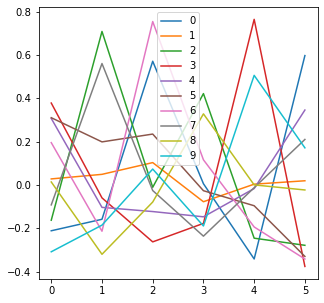

In [9]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

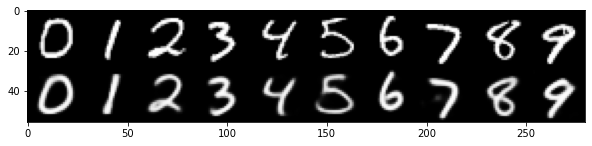

In [10]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [11]:
exn = 5

In [12]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

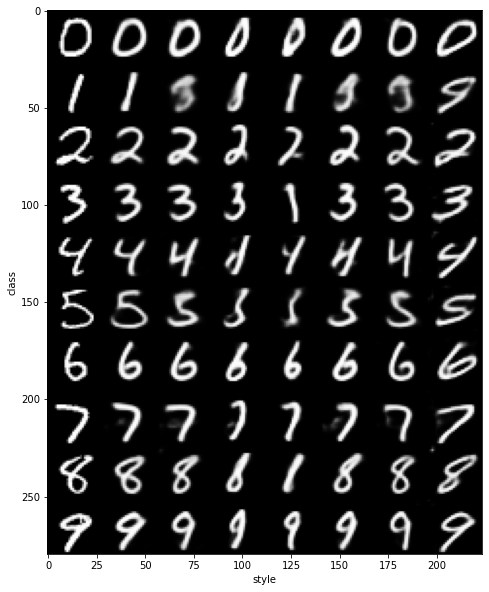

In [13]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [14]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

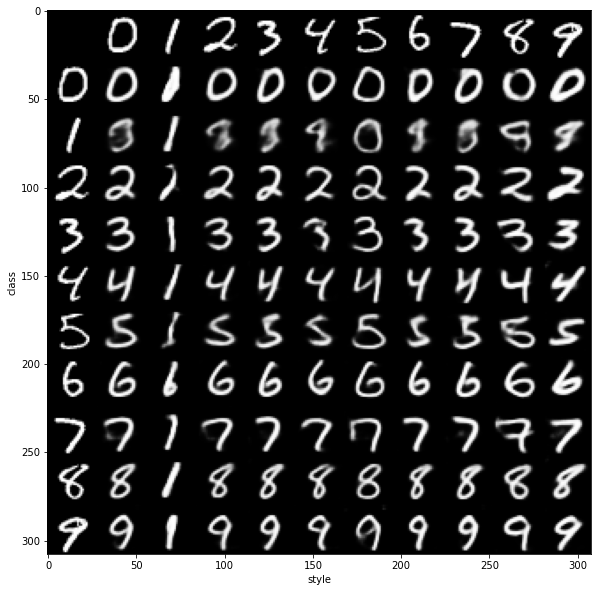

In [15]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()